<a href="https://colab.research.google.com/github/aettikang/DataAnalysisPlan/blob/main/IEEE_CIS_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 데이터 불러오기 및 기본 설정

In [12]:
import os
import pandas as pd
import numpy as np
#os.chdir("/content/drive/MyDrive/cuk/데이터분석기획/")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (20, 5)

import warnings
warnings.filterwarnings("ignore")

#### 1.1 데이터 불러오기 및 불필요한 변수 삭제

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/aettikang/DataAnalysisPlan/main/sampled_train_transaction.csv')

In [ ]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True) # 도메인 지식하에, 불필요한 변수라 판단하여 삭제

#### 1.2 데이터 분리

In [16]:
X = df.drop(['isFraud'], axis = 1)
Y = df['isFraud']

from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

## 2. 변수 탐색

#### 2.1 라벨 확인
- 사기 거래가 아닌 거래가 전체 거래의 97.4%를 차지
- 클래스 불균형 문제가 발생할 확률이 매우 높아보임

In [17]:
Train_Y.value_counts(normalize = True)

0    0.97476
1    0.02524
Name: isFraud, dtype: float64

In [18]:
Train_Y.value_counts(normalize = False)

0    73107
1     1893
Name: isFraud, dtype: int64

#### 2.2 변수별 상태 공간 확인: 컬럼별 유니크한 값 일부 확인

탐색 내용 <br>
- TransactionAmt는 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- ProductCD, card4, card6은 범주형 변수임이 확실해보임 (결측 포함)
- P_emaildomain, R_emaildomain은 구매자의 이메일 도메인으로 보임. 직관적으로 봤을 때, 유의한 의미가 있을지 의심되며, 둘은 관계가 있을 것으로 보임
- card1, card2, card3, card5은 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- 많은 변수에서 결측이 포함되어 있음
- C3를 제외한 C1 ~ C14는 모두 연속형 변수인 것으로 보임. 비식별화되어 있어 대략적인 의미라도 추측을 해야 함
- 결측이 매우 많아, 곧바로 대체하기에는 부담이 있어, 결측 분포 확인 필요
- M1 ~ M9는 매칭 정보이며, 전부 범주형 변수임이 확실함. T는 매칭됨, F는 매칭되지 않음을 나타내는 것으로 보이며, 모두 결측이 포함

In [19]:
for col in Train_X.columns:
    print("변수: {}, 타입: {}, 결측 개수: {}, 상태공간 크기: {}, 상태공간 일부: {}".format(col, Train_X[col].dtype, Train_X[col].isnull().sum(), len(Train_X[col].unique()), Train_X[col].unique()[:5]))

변수: TransactionAmt, 타입: float64, 결측 개수: 0, 상태공간 크기: 5443, 상태공간 일부: [100.   200.   110.25 117.    25.  ]
변수: ProductCD, 타입: object, 결측 개수: 0, 상태공간 크기: 5, 상태공간 일부: ['R' 'S' 'W' 'H' 'C']
변수: card1, 타입: int64, 결측 개수: 0, 상태공간 크기: 6833, 상태공간 일부: [15484  1607  3682 16566 16132]
변수: card2, 타입: float64, 결측 개수: 1021, 상태공간 크기: 498, 상태공간 일부: [418. 542. 264. 583. 111.]
변수: card3, 타입: float64, 결측 개수: 2, 상태공간 크기: 71, 상태공간 일부: [150. 185. 214. 144. 119.]
변수: card4, 타입: object, 결측 개수: 3, 상태공간 크기: 5, 상태공간 일부: ['visa' 'mastercard' 'american express' 'discover' nan]
변수: card5, 타입: float64, 결측 개수: 383, 상태공간 크기: 80, 상태공간 일부: [226. 162. 224. 117. 144.]
변수: card6, 타입: object, 결측 개수: 2, 상태공간 크기: 5, 상태공간 일부: ['debit' 'credit' 'debit or credit' 'charge card' nan]
변수: P_emaildomain, 타입: object, 결측 개수: 11594, 상태공간 크기: 60, 상태공간 일부: ['aol.com' 'gmail.com' nan 'hotmail.com' 'yahoo.com']
변수: R_emaildomain, 타입: object, 결측 개수: 49090, 상태공간 크기: 61, 상태공간 일부: ['anonymous.com' 'hotmail.com' nan 'gmail.com' 'icloud.com']
변수: C

#### 2.3 탐색을 위한 데이터 준비: 특징과 라벨 데이터 병합

In [20]:
Train_df = pd.concat([Train_X, Train_Y], axis = 1)
Train_df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,...,M1,M2,M3,M4,M5,M6,M7,M8,M9,isFraud
55193,100.00,R,15484,418.0,150.0,visa,226.0,debit,aol.com,anonymous.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36181,200.00,R,1607,542.0,150.0,visa,226.0,debit,gmail.com,hotmail.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
62850,110.25,S,3682,264.0,150.0,visa,162.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
38103,117.00,W,3682,264.0,150.0,visa,226.0,credit,hotmail.com,NaN,...,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,0
63364,25.00,H,16566,583.0,150.0,mastercard,224.0,credit,yahoo.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### 2.4 범주형 변수 탐색
(1) 결측을 문자로 변환 (탐색을 위해 임시 변환) <br>
(2) 변수별 분포 확인 (bar plot) <br>
(3) 변수와 특징 간 관계 확인 (groupby)

2.4.1 ProductCD

In [48]:
Train_df['ProductCD'].isnull().sum() # 결측이 전혀없어서, 결측을 문자로 변환할 필요 없음

0

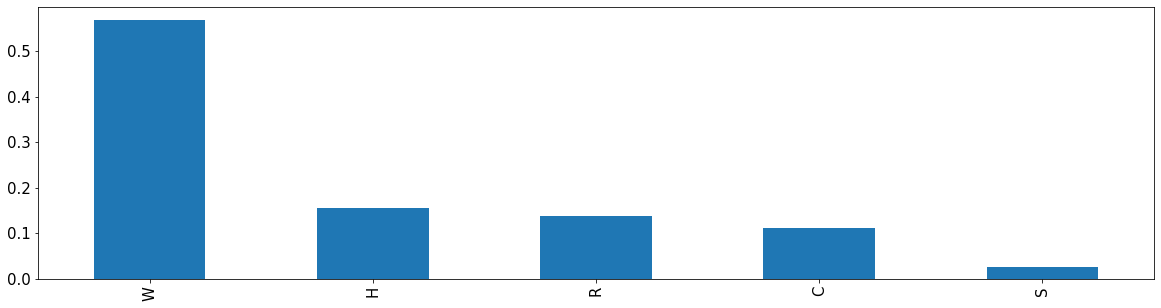

In [49]:
Train_df['ProductCD'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# ProdudctCD가 W가 매우 높은 비율을 차지하며, S는 1% 가량됨을 확인

In [50]:
# 상품별로 차이가 존재함을 확인 (다만, H와 W는 거의 유사하다고 판단됨)
# 상태 공간의 크기가 그리 크지 않으니, 굳이 변수 값의 군집화는 수행하지 않고 더미화를 하기로 결정
Train_df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.087601
H    0.019332
R    0.010330
S    0.022408
W    0.018266
Name: isFraud, dtype: float64

2.4.2 card4

In [51]:
Train_df['card4'].isnull().sum() # 결측이 6개밖에 되지 않음 ==> 전부 최빈값으로 대체

3

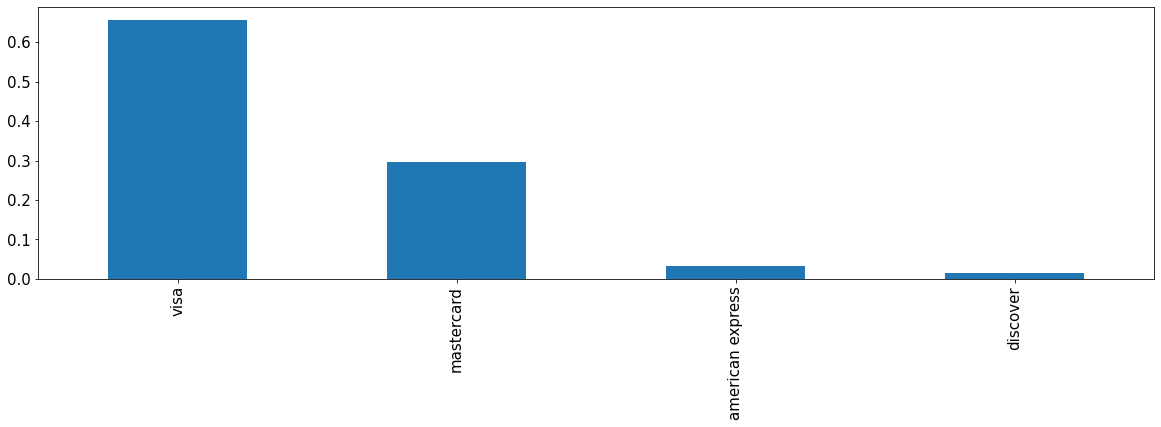

In [52]:
Train_df['card4'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# visa와 master card가 매우 높은 비율을 차지하며, discover는 거의 발생하지 않음

In [53]:
# 거래의 대다수를 차지하는 visa와 mastercard의 값이 유사
# american express만 유독 값이 작으며 해당 값의 빈도가 높지 않음 => 해당 변수를 american express란 변수로 이진화
# 따라서 결측을 특별히 제거할 필요가 없음
Train_df.groupby('card4')['isFraud'].mean()

card4
american express    0.009581
discover            0.025501
mastercard          0.028480
visa                0.024531
Name: isFraud, dtype: float64

2.4.3 card6

In [54]:
Train_df['card6'].isnull().sum() # 결측이 4개밖에 되지 않음 ==> 전부 최빈값으로 대체

2

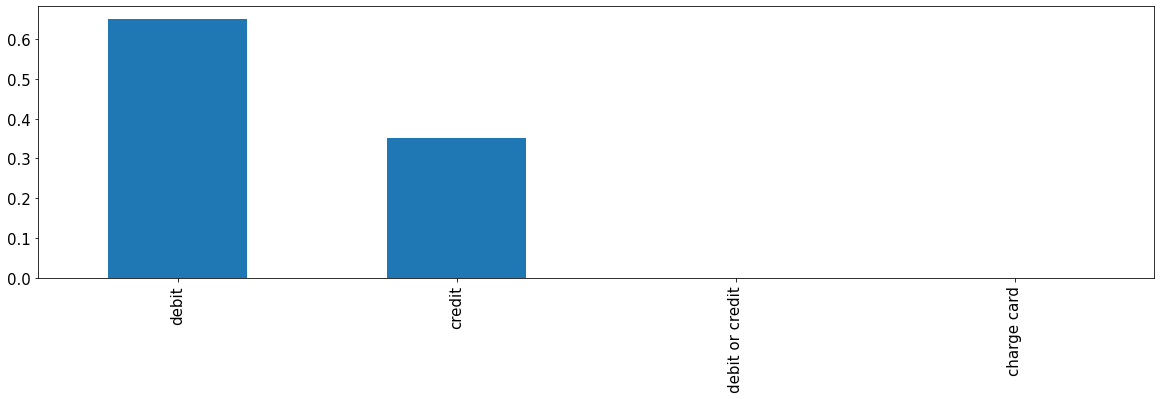

In [55]:
Train_df['card6'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# debit과 credit이 대다수를 차지. 다른 값들은 육안으로 확인이 불가능한 수준

In [56]:
Train_df['card6'].value_counts(normalize = False) # debit or credit, charge card는 빈도가 매우 적음

debit              48716
credit             26275
debit or credit        5
charge card            2
Name: card6, dtype: int64

In [57]:
# credit과 debit의 차이가 존재
# charge card, debit or credit은 전부 0임을 확인 ==> 그러나 빈도 자체가 매우 적어서 그런 것이라 예상됨
# 따라서 credit인지 나타내는 변수로만 변환
Train_df.groupby('card6')['isFraud'].mean()

card6
charge card        0.000000
credit             0.034672
debit              0.020117
debit or credit    0.000000
Name: isFraud, dtype: float64

2.4.4 P_emaildomain과 R_emaildomain

- 이전 탐색에서 각각의 상태 공간 크기가 60, 61임을 확인 (대다수가 gmail 혹은 yahoo 메일임)
- 또한, 결측이 매우 많았는데, email이 결측이라는 것이 어떤 의미가 있을것이라 의심됨
- 샘플의 개수를 고려하더라도 그 크기가 큰 범주형 변수라고 판단 가능
- 두 변수간 관계가 있으리라 쉽게 판단 가능
- 또한, .를 기준으로 앞쪽에는 실제 도메인이, 뒤쪽에는 com, net 등이 포함되어 있어 분할 필요

In [58]:
Train_df['P_emaildomain'].value_counts()

gmail           27312
yahoo           12167
anonymous        6524
hotmail          6138
aol              3620
comcast          1407
icloud            687
msn               619
outlook           609
att               531
sbcglobal         485
live              478
verizon           460
bellsouth         321
cox               288
me                273
ymail             270
charter           174
optonline         142
mac                91
rocketmail         82
earthlink          68
embarqmail         56
netzero            53
mail               52
roadrunner         51
juno               51
windstream         45
twc                39
frontier           34
q                  34
web                32
aim                27
prodigy            27
frontiernet        27
cfl                23
suddenlink         20
ptd                17
cableone           17
centurylink        16
gmx                14
sc                 12
protonmail          8
servicios-ta        5
Name: P_emaildomain, dtype: int6

In [59]:
Train_df['R_emaildomain'].value_counts()

gmail           9720
anonymous       5235
hotmail         4139
yahoo           2699
aol              991
comcast          595
outlook          362
icloud           239
live             239
msn              224
verizon          187
sbcglobal        175
cox              168
me               143
bellsouth        139
att              127
ymail             61
optonline         49
mac               46
web               31
charter           30
mail              28
prodigy           27
embarqmail        25
frontier          22
earthlink         21
juno              21
windstream        20
roadrunner        17
rocketmail        15
gmx               14
cfl               14
q                 14
suddenlink        12
ptd                9
netzero            9
twc                8
frontiernet        8
cableone           5
aim                5
centurylink        5
servicios-ta       5
scranton           4
sc                 2
protonmail         1
Name: R_emaildomain, dtype: int64

In [60]:
# 결측이 의미가 있는지 확인 (두 변수 모두 결측이 많다는 것은 위에서 확인함)
# 결측을 나타내는 변수 생성
Train_df['NA_P_emaildomain'] = Train_df['P_emaildomain'].isnull().astype(int)
Train_df['NA_R_emaildomain'] = Train_df['R_emaildomain'].isnull().astype(int)

In [61]:
# P_emaildomain은 크게 문제 없어보임
Train_df.groupby('NA_P_emaildomain')['isFraud'].mean()

NA_P_emaildomain
0    0.025723
1    0.022598
Name: isFraud, dtype: float64

In [62]:
# R_emaildomain은 오히려 결측이 발생하지 않았을 때 사기인 경우가 더 많음을 확인 ==> 변수로 활용
Train_df.groupby('NA_R_emaildomain')['isFraud'].mean()

NA_R_emaildomain
0    0.040718
1    0.017071
Name: isFraud, dtype: float64

In [63]:
# 유의한 도메인만 가져와서 추가 탐색 수행
Train_df['P_emaildomain'] = Train_df['P_emaildomain'].str.split('.', expand = True).iloc[:, 0]
Train_df['R_emaildomain'] = Train_df['R_emaildomain'].str.split('.', expand = True).iloc[:, 0]

In [64]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, aim.com, cableone.net 등은 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
aim             0.000000
anonymous       0.009197
aol             0.012983
att             0.007533
bellsouth       0.000000
cableone        0.058824
centurylink     0.000000
cfl             0.000000
charter         0.005747
comcast         0.009240
cox             0.003472
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.074074
gmail           0.034856
gmx             0.000000
hotmail         0.047084
icloud          0.033479
juno            0.000000
live            0.025105
mac             0.000000
mail            0.134615
me              0.018315
msn             0.017771
netzero         0.000000
optonline       0.000000
outlook         0.054187
prodigy         0.000000
protonmail      0.125000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.002062
sc              0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc             0.000000
verizon    

In [65]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, 대다수 값이 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
aim             0.000000
anonymous       0.008405
aol             0.007064
att             0.000000
bellsouth       0.000000
cableone        0.000000
centurylink     0.000000
cfl             0.000000
charter         0.000000
comcast         0.015126
cox             0.005952
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.000000
gmail           0.063580
gmx             0.000000
hotmail         0.062576
icloud          0.041841
juno            0.000000
live            0.004184
mac             0.000000
mail            0.107143
me              0.000000
msn             0.004464
netzero         0.000000
optonline       0.000000
outlook         0.074586
prodigy         0.000000
protonmail      1.000000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.000000
sc              0.000000
scranton        0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc        

In [66]:
# 같은 거래라면 P_emaildomain과 R_emaildomain이 특정 관계가 있지 않을까?
# 파생 변수 추가 및 확인: 실제 라벨의 분포를 고려했을 때, 1%와 5%의 차이는 꽤 큰 것이라 예상됨 ==> 해당 변수 사용
Train_df['same_emaildomain'] = (Train_df['P_emaildomain'] == Train_df['R_emaildomain']).astype(int)
print(Train_df['same_emaildomain'].value_counts())
print('\n')
print(Train_df.groupby('same_emaildomain')['isFraud'].mean())

0    56171
1    18829
Name: same_emaildomain, dtype: int64


same_emaildomain
0    0.016557
1    0.051145
Name: isFraud, dtype: float64


2.4.5 C3

In [67]:
# 결측이 없음을 이전에서 확인
# 변수 타입은 float인데, 상태 공간의 크기가 크지 않음 ==> 일단은 범주형으로 보는 것이 적절할 것 같음

In [68]:
# 0.0 값이 대다수임을 확인
Train_df['C3'].value_counts(normalize = True)

0.0     0.988400
1.0     0.010787
2.0     0.000693
3.0     0.000067
8.0     0.000013
16.0    0.000013
9.0     0.000013
4.0     0.000013
Name: C3, dtype: float64

In [69]:
Train_df['C3'].value_counts(normalize = False)

0.0     74130
1.0       809
2.0        52
3.0         5
8.0         1
16.0        1
9.0         1
4.0         1
Name: C3, dtype: int64

In [70]:
# 2.0 이상의 값은 거의 존재하지 않기 때문에, 우연히 평균이 0이 나왔을 것이란 추측이 가능
# 0.0은 자주 등장했기 때문에, 라벨의 평균과 유사
# 1.0은 빈도가 어느정도 있음에도 불구하고 라벨의 평균과 크게 다름
# (조금은 위험한) 가설 수립: C3값이 1 이상인지 아닌지에 따른 차이가 존재할 것이다! => C3_over_1 변수 생성
Train_df.groupby('C3')['isFraud'].mean()

C3
0.0     0.025523
1.0     0.001236
2.0     0.000000
3.0     0.000000
4.0     0.000000
8.0     0.000000
9.0     0.000000
16.0    0.000000
Name: isFraud, dtype: float64

In [71]:
Train_Y.value_counts(normalize = True)

0    0.97476
1    0.02524
Name: isFraud, dtype: float64

2.4.6 M 관련 변수
- M1 - M9는 결측도 절반가까이를 포함하여, 대체하는 것은 어려을 것으로 예상됨
- 모두 범주형 변수이며, 값의 출현 패턴이 유사하니 동시에 탐색 수행

In [72]:
# 탐색을 위해, 모든 결측값을 우선 대체
M_columns = ['M' + str(i) for i in range(1, 10)]
Train_df[M_columns] = Train_df[M_columns].fillna("결측")

In [73]:
## 변수 분포 확인
# 1. 결측이 매우 많음 => 단순 대체 및 제거 불가
# 2. M4를 제외하고는 T (True), F (False로 정의됨)
for col in M_columns:
    print(Train_df[col].value_counts())
    print('\n')

결측    51353
T     23647
Name: M1, dtype: int64


결측    51353
T     21289
F      2358
Name: M2, dtype: int64


결측    51353
T     18514
F      5133
Name: M3, dtype: int64


결측    43301
M0    19609
M2     7012
M1     5078
Name: M4, dtype: int64


결측    51674
F     12914
T     10412
Name: M5, dtype: int64


결측    34229
F     21914
T     18857
Name: M6, dtype: int64


결측    62922
F     10361
T      1717
Name: M7, dtype: int64


결측    62922
F      7512
T      4566
Name: M8, dtype: int64


결측    62922
T     10335
F      1743
Name: M9, dtype: int64




In [74]:
## 변수 값별 라벨 확인: 값별로 차이가 있으며, 결측 자체로도 의미가 있어보임
# 결측으로 대체 후 더미화 필요
for col in M_columns:
    print(Train_df.groupby(col)['isFraud'].mean())
    print('\n')

M1
T     0.016915
결측    0.029073
Name: isFraud, dtype: float64


M2
F     0.030534
T     0.015407
결측    0.029073
Name: isFraud, dtype: float64


M3
F     0.027859
T     0.013881
결측    0.029073
Name: isFraud, dtype: float64


M4
M0    0.035953
M1    0.019496
M2    0.086423
결측    0.011154
Name: isFraud, dtype: float64


M5
F     0.018507
T     0.042451
결측    0.023455
Name: isFraud, dtype: float64


M6
F     0.024505
T     0.012038
결측    0.032984
Name: isFraud, dtype: float64


M7
F     0.013802
T     0.006407
결측    0.027637
Name: isFraud, dtype: float64


M8
F     0.014244
T     0.010293
결측    0.027637
Name: isFraud, dtype: float64


M9
F     0.014917
T     0.012385
결측    0.027637
Name: isFraud, dtype: float64




#### 2.5 연속형 변수 탐색
(1) 변수별 분포 확인 (히스토그램) <br>
(2) 변수와 라벨 간 관계 파악 (박스플롯)

2.5.1 TransactionAmt

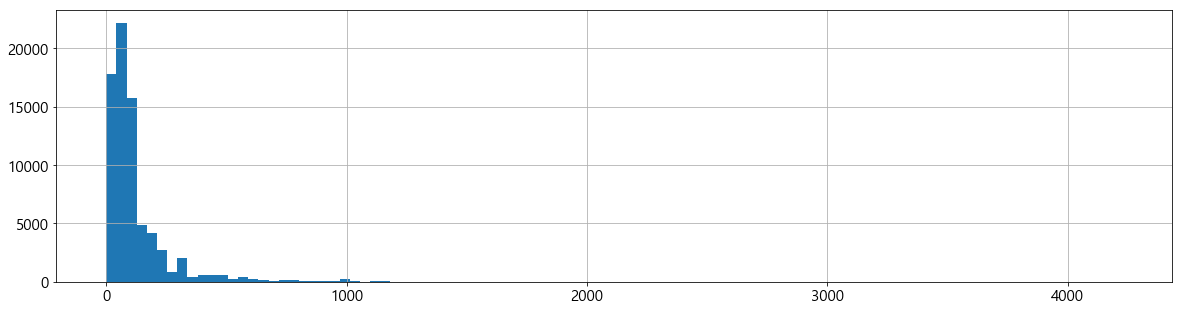

In [ ]:
# 히스토그램 생성: 대다수가 1000달러 이하임을 확인 (거기다가 굉장히 치우침을 확인)
Train_df['TransactionAmt'].hist(bins = 100)

In [ ]:
# 한쪽에 매우 치우침을 확인함: 거래 금액이 매우 크거나 작은 것 자체가 특징이 되지 않을까?
Train_df['TransactionAmt'].describe()

count    75000.000000
mean       130.105657
std        203.781211
min          0.292000
25%         45.000000
50%         75.000000
75%        135.950000
max       4220.390000
Name: TransactionAmt, dtype: float64

([<matplotlib.axis.XTick at 0x29f6f1dbd68>,
 <a list of 2 Text xticklabel objects>)

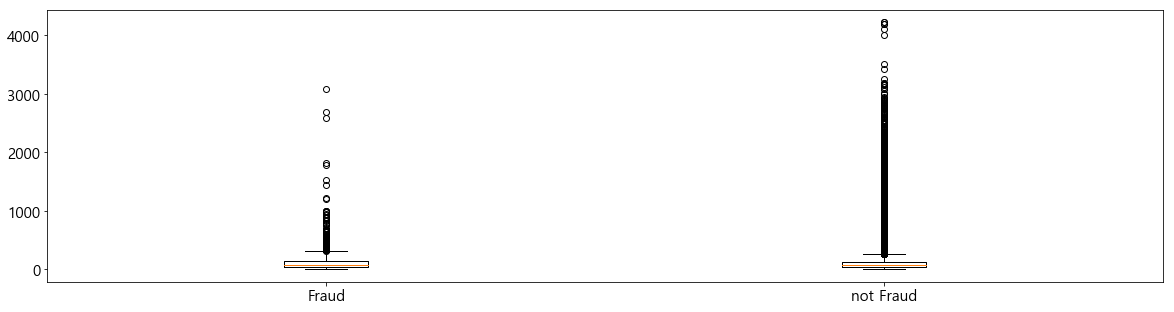

In [ ]:
TransactionAmt_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 1]
TransactionAmt_not_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 0]

# 대부분 이상치로 판단되어 정상적인 해석이 쉽지 않음 (다만, Fraud인 경우의 범위가 더 좁음)
plt.boxplot([TransactionAmt_Fraud, TransactionAmt_not_Fraud])
plt.xticks([1, 2], ['Fraud', 'not Fraud'])

In [ ]:
# 사기 거래의 경우
TransactionAmt_Fraud.describe()

count    1921.000000
mean      131.807672
std       189.742205
min         0.292000
25%        39.000000
50%        77.950000
75%       150.000000
max      3081.970000
Name: TransactionAmt, dtype: float64

In [ ]:
# 사기 거래가 아닌 경우
TransactionAmt_not_Fraud.describe()

count    73079.000000
mean       130.060917
std        204.138246
min          1.000000
25%         45.000000
50%         75.000000
75%        134.950000
max       4220.390000
Name: TransactionAmt, dtype: float64

In [ ]:
# 특별한 관계를 찾기는 어려움: 또한, 사기 거래인 경우에는 데이터가 많아서 범위가 커보일 수 있음 
# 따라서 라벨과 관계를 고려하지 않고, 치우침만 해결하기로 결정

2.5.2 C 관련 변수 (C3 제외)

In [ ]:
# 변수 목록 생성
C_columns = ['C' + str(i) for i in range(1, 15) if i != 3]
C_columns

['C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [ ]:
# 대다수의 변수가 75%값은 10미만인데, max값은 매우 큼 ==> 이상하다?
Train_df[C_columns].describe()

,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,40.290573,47.037000,18.808840,4.135253,22.76164,15.616080,25.70180,3.253973,26.331133,29.187573,21.867987,44.953573,16.716067
std,306.941439,358.244826,155.754386,21.445987,156.51016,149.123686,228.21086,13.936151,229.355469,214.992758,209.211321,218.576029,102.373166
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,2.000000,2.000000,1.000000,1.000000,2.00000,0.000000,1.00000,1.000000,1.000000,2.000000,0.000000,9.000000,2.000000
max,4685.000000,5691.000000,2253.000000,295.000000,2253.00000,2255.000000,3331.00000,194.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [ ]:
# 상위 90% 값 확인
Train_df[C_columns].quantile(0.90)

C1      6.0
C2      6.0
C4      1.0
C5      2.0
C6      4.0
C7      1.0
C8      1.0
C9      3.0
C10     1.0
C11     4.0
C12     1.0
C13    33.0
C14     5.0
Name: 0.9, dtype: float64

In [ ]:
# 상위 95%값 확인
Train_df[C_columns].quantile(0.95)

C1      45.0
C2      48.0
C4       2.0
C5       5.0
C6      28.0
C7       1.0
C8       2.0
C9       6.0
C10      2.0
C11     29.0
C12      1.0
C13    153.0
C14     26.0
Name: 0.95, dtype: float64

In [ ]:
# 상위 99%값 확인
Train_df[C_columns].quantile(0.99)

C1     1183.00
C2     1482.00
C4      804.00
C5      135.00
C6      814.00
C7      624.03
C8      901.04
C9       82.00
C10    1030.05
C11     919.02
C12     854.03
C13     884.00
C14     565.00
Name: 0.99, dtype: float64

In [ ]:
# C 관련 변수는 모두 치우침이 매우 심각함
# 상위 95%값과 99% 값의 차이가 너무 많이 남
# 변수로 활용하기 어려워보임 ==> 이진화를 하기에는 자르는 구간 설정이 어려움 ==> 해당 특징을 사용하려면 트리 계열 모델 사용이 필수적

card1, 2, 3, 5

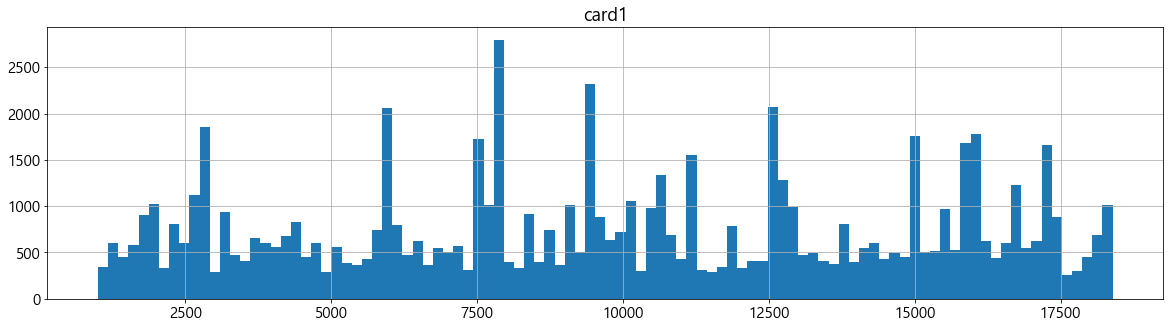

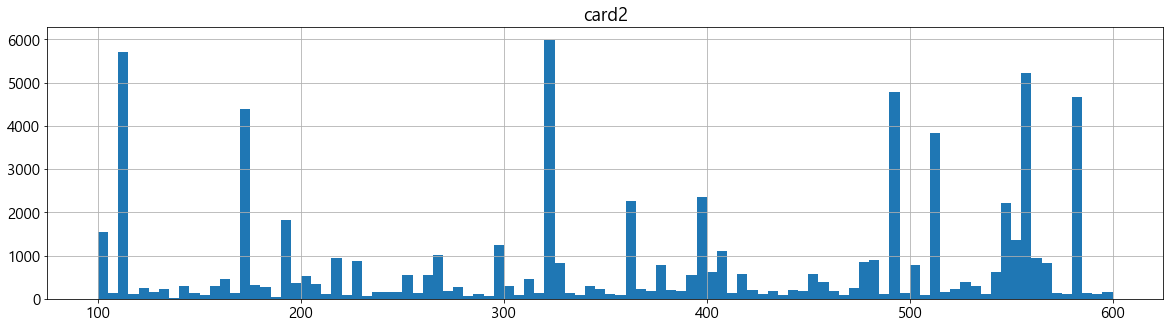

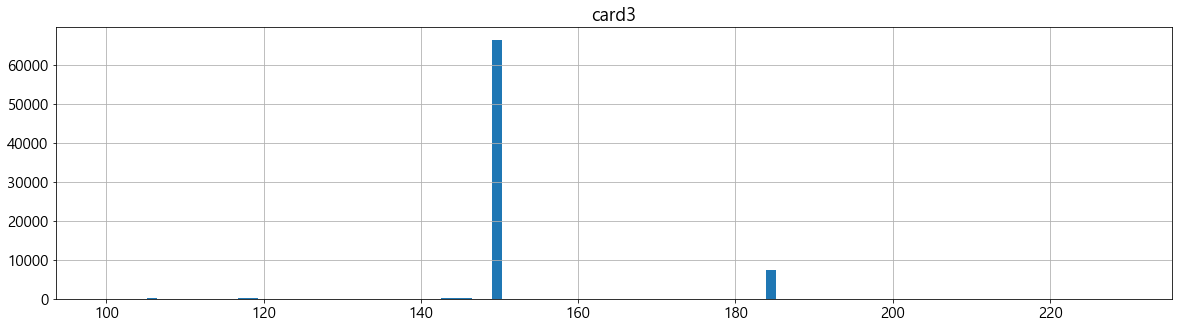

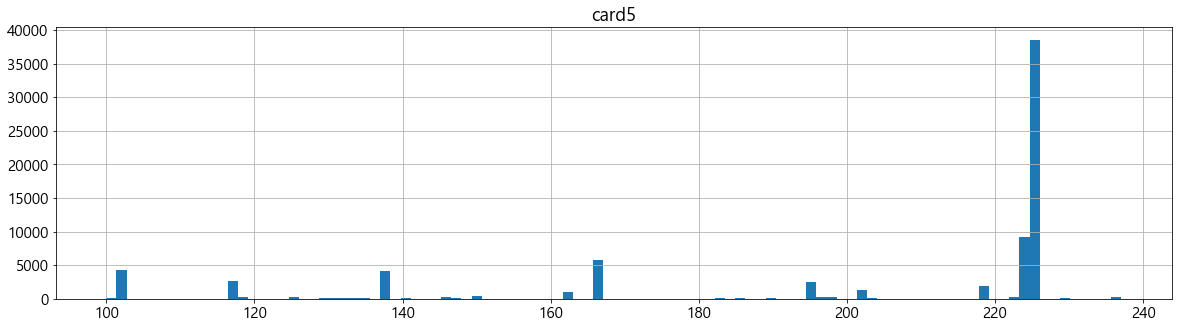

In [ ]:
# 히스토그램 확인: card3과 card5의 분포가 특이함 (치우침이 특정 방향으로 일어나지는 않았음. 사실상 범주 변수로 보는 것이 바람직)
# 연속형 변수로 간주할 수 있는 card1과 card3은 결측 처리 필요
card_columns = ['card1', 'card2', 'card3', 'card5']
for col in card_columns:
    plt.title(col)
    Train_df[col].hist(bins = 100)
    plt.show()

In [ ]:
# 값의 분포 확인
Train_df[card_columns].describe()

,card1,card2,card3,card5
count,75000.000000,73971.000000,74998.000000,74615.000000
mean,9887.017360,370.707385,153.267874,200.036588
std,4928.893866,159.303931,11.194380,40.920570
min,1001.000000,100.000000,100.000000,100.000000
25%,6019.000000,215.000000,150.000000,166.000000
50%,9678.000000,387.000000,150.000000,226.000000
75%,14290.000000,514.000000,150.000000,226.000000
max,18393.000000,600.000000,229.000000,237.000000


In [ ]:
Train_df['card3'].value_counts() # 150인지, 185인지 아닌지를 나타내는 변수로 변환 필요

150.0    66439
185.0     7298
144.0      212
106.0      142
146.0      122
117.0      117
143.0       99
119.0       77
102.0       55
147.0       41
162.0       34
213.0       25
197.0       21
131.0       21
100.0       20
188.0       18
134.0       18
203.0       17
214.0       16
195.0       16
138.0       14
135.0       13
210.0       11
200.0       11
148.0       11
142.0        9
137.0        8
121.0        8
166.0        7
149.0        7
         ...  
171.0        3
229.0        2
190.0        2
116.0        2
153.0        2
129.0        2
204.0        2
183.0        2
222.0        2
152.0        2
227.0        2
120.0        2
130.0        2
127.0        1
199.0        1
207.0        1
156.0        1
163.0        1
167.0        1
132.0        1
191.0        1
225.0        1
198.0        1
206.0        1
177.0        1
111.0        1
109.0        1
215.0        1
208.0        1
186.0        1
Name: card3, Length: 70, dtype: int64

In [ ]:
Train_df['card3_150'] = (Train_df['card3'] == 150).astype(int)
Train_df['card3_185'] = (Train_df['card3'] == 185).astype(int)

In [ ]:
Train_df.groupby('card3_150')['isFraud'].mean() # 차이가 있음을 확인

card3_150
0    0.085854
1    0.017851
Name: isFraud, dtype: float64

In [ ]:
Train_df.groupby('card3_185')['isFraud'].mean() # 차이가 있음을 확인

card3_185
0    0.017799
1    0.098109
Name: isFraud, dtype: float64

In [ ]:
Train_df['card5'].value_counts() # 226인지 아닌지를 나타내는 변수로 변환 필요

226.0    38505
224.0     9152
166.0     5771
102.0     4292
117.0     2691
138.0     2558
195.0     2448
219.0     1931
137.0     1545
202.0     1254
162.0      960
150.0      418
197.0      309
223.0      231
146.0      222
118.0      213
198.0      206
126.0      201
236.0      193
190.0      165
185.0      143
100.0      129
132.0       78
131.0       78
119.0       75
147.0       73
129.0       70
183.0       65
203.0       61
141.0       57
         ...  
106.0        5
148.0        4
139.0        4
225.0        3
143.0        3
156.0        3
121.0        2
157.0        2
171.0        2
113.0        2
152.0        2
180.0        2
217.0        2
136.0        1
181.0        1
107.0        1
184.0        1
189.0        1
200.0        1
210.0        1
167.0        1
122.0        1
169.0        1
187.0        1
211.0        1
201.0        1
204.0        1
164.0        1
214.0        1
120.0        1
Name: card5, Length: 84, dtype: int64

In [ ]:
Train_df['card5_226'] = (Train_df['card5'] == 226).astype(int)

In [ ]:
Train_df.groupby('card5_226')['isFraud'].mean() # 차이가 있음을 확인

card5_226
0    0.030278
1    0.021192
Name: isFraud, dtype: float64

## 3. 데이터 전처리

#### 3.1 이진화

card4 이진화

In [ ]:
Train_X['american_express'] = (Train_X.loc[:, 'card4'] == 'american express').astype(int)
Train_X.drop('card4', axis = 1, inplace = True)

In [ ]:
Test_X['american_express'] = (Test_X.loc[:, 'card4'] == 'american express').astype(int)
Test_X.drop('card4', axis = 1, inplace = True)

card6 이진화

In [ ]:
Train_X['credit'] = (Train_X.loc[:, 'card6'] == 'credit').astype(int)
Train_X.drop('card6', axis = 1, inplace = True)

In [ ]:
Test_X['credit'] = (Test_X.loc[:, 'card6'] == 'credit').astype(int)
Test_X.drop('card6', axis = 1, inplace = True)

same_email 변수 추가 및 기존 변수 삭제

In [ ]:
Train_X['NA_R_emaildomain'] = (Train_X['R_emaildomain'].isnull()).astype(int)
Train_X['same_emaildomain'] = (Train_X['P_emaildomain'] == Train_X['R_emaildomain']).astype(int)
Train_X.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)

In [ ]:
Test_X['NA_R_emaildomain'] = (Test_X['R_emaildomain'].isnull()).astype(int)
Test_X['same_emaildomain'] = (Test_X['P_emaildomain'] == Test_X['R_emaildomain']).astype(int)
Test_X.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)

C3_over_1 변수 생성

In [ ]:
Train_X['C3_over_1'] = (Train_X['C3'] >= 1).astype(int)
Train_X.drop(['C3'], axis = 1, inplace = True)

In [ ]:
Test_X['C3_over_1'] = (Test_X['C3'] >= 1).astype(int)
Test_X.drop(['C3'], axis = 1, inplace = True)

#### 3.2 결측 대체 및 더미화 수행

In [ ]:
from feature_engine.categorical_encoders import OneHotCategoricalEncoder as OHE
Train_X[M_columns] = Train_X[M_columns].fillna("결측")
dummy_model = OHE(variables = M_columns + ['ProductCD'], drop_last = True).fit(Train_X)
Train_X = dummy_model.transform(Train_X)

ModuleNotFoundError: ignored

In [ ]:
from feature_engine.categorical_encoders import OneHotCategoricalEncoder as OHE
Test_X[M_columns] = Test_X[M_columns].fillna("결측")
Test_X = dummy_model.transform(Test_X)

#### 3.3 치우침 해소

In [ ]:
Train_X['TransactionAmt'] = np.log(Train_X['TransactionAmt'])

In [ ]:
Test_X['TransactionAmt'] = np.log(Test_X['TransactionAmt'])

#### 3.4 연속형 변수를 이진화

In [ ]:
Train_X['card3_150'] = (Train_X['card3'] == 150).astype(int)
Train_X['card3_185'] = (Train_X['card3'] == 185).astype(int)
Train_X['card5_226'] = (Train_X['card5'] == 226).astype(int)

Train_X.drop(['card3', 'card5'], axis = 1, inplace = True)

In [ ]:
Test_X['card3_150'] = (Test_X['card3'] == 150).astype(int)
Test_X['card3_185'] = (Test_X['card3'] == 185).astype(int)
Test_X['card5_226'] = (Test_X['card5'] == 226).astype(int)

Test_X.drop(['card3', 'card5'], axis = 1, inplace = True)

#### 3.5 결측 대체 (주의: 특정 값을 기준으로 이진화하려면 결측 대체가 마지막에 나와야 함!)

In [ ]:
from sklearn.impute import SimpleImputer as SI
imputer = SI().fit(Train_X)
Train_X = pd.DataFrame(imputer.transform(Train_X), columns = Train_X.columns)
Test_X = pd.DataFrame(imputer.transform(Test_X), columns = Train_X.columns)

ValueError: ignored

#### 3.6 클래스 불균형 문제

In [ ]:
# 현재 클래스 간 빈도차이가 매우 심각함을 확인 (97: 3 정도의 비율)
# 전체 샘플 수가 10만개이므로, 오버샘플링을 수행하기에는 부적절
# 언더샘플링을 수행하게 되면 남는 샘플이 약 4천개이며, 특징 수가 그리 많지 않음 ==> 언더샘플링 혹은 비용 민감 모델 고려 필요

### 4. 모델 학습
- 사용 모델: Tree 기반의 앙상블 (Random Forest, XGBoost) 
- 언더샘플링과 비용민감모델 동시 고려

모델 파라미터 그리드 설계

In [ ]:
import copy
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from imblearn.under_sampling import NearMiss

# 언더샘플링이 적용된 데이터에 사용할 그리드 생성 (복사를 위해, ParameterGrid를 일단 적용하지 않음)
RF_grid = dict({"n_estimators":[100, 200],
               "max_depth":[3, 4, 5, 6]})

XGB_grid = dict({"n_estimators":[100, 200],
               "max_depth":[3, 4, 5, 6],
                "learning_rate":[0.05, 0.1, 0.2]})

# 언더샘플링이 적용되지 않은 데이터에 사용할 그리드 생성
class_imbalance_ratio = sum(Train_Y == 0) / sum(Train_Y == 1)
RF_cs_grid = copy.copy(RF_grid)
RF_cs_grid['class_weight'] = [{1:class_imbalance_ratio * w, 0:1} for w in [1, 0.9, 0.7, 0.5]]

XGB_cs_grid = copy.copy(XGB_grid)
XGB_cs_grid['class_weight'] = [{1:class_imbalance_ratio * w, 0:1} for w in [1, 0.9, 0.7, 0.5]]

RF_grid = ParameterGrid(RF_grid)
RF_cs_grid = ParameterGrid(RF_cs_grid)
XGB_grid = ParameterGrid(XGB_grid)
XGB_cs_grid = ParameterGrid(XGB_cs_grid)

Using TensorFlow backend.


In [ ]:
# 최종 그리드 생성 및 모델 테스트 함수 생성
grid_for_cs_model = {RFC:RF_cs_grid, XGB:XGB_cs_grid}
grid_for_not_cs_model = {RFC:RF_grid, XGB:XGB_grid}

from sklearn.metrics import f1_score
def model_test(model, test_x, test_y):
    pred_Y = model.predict(test_x)
    return f1_score(test_y, pred_Y)

파라미터 튜닝 

In [ ]:
# 비용 민감 모델 테스트
# 최고값 초기화

best_score = -1
max_iter = 0
for k in range(34, 4, -5): 
    for model_func in grid_for_cs_model:
        for parameter in grid_for_cs_model[model_func]:            
            max_iter += 1

# 데이터 꼬임을 방지하기 위해 데이터 복제
T_X = Train_X.copy() 
t_X = Test_X.copy()

num_iter = 1
for k in range(34, 4, -5): 
    selector = SelectKBest(mutual_info_classif, k = k).fit(T_X, Train_Y)
    selected_columns = T_X.columns[selector.get_support()]
    T_X = T_X[selected_columns]
    t_X = t_X[selected_columns]
    for model_func in grid_for_cs_model:
        for parameter in grid_for_cs_model[model_func]:            
            model = model_func(**parameter).fit(T_X, Train_Y)
            score = model_test(model, t_X, Test_Y)
            if score > best_score:
                best_model = model
                best_features = selected_columns
                best_score = score            
                                
            print(num_iter, "/", max_iter, best_score)
            num_iter += 1            

1 / 768 0.20132450331125828
2 / 768 0.20132450331125828
3 / 768 0.20132450331125828
4 / 768 0.20132450331125828
5 / 768 0.20132450331125828
6 / 768 0.20132450331125828
7 / 768 0.20132450331125828
8 / 768 0.20132450331125828
9 / 768 0.22966867469879515
10 / 768 0.22966867469879515
11 / 768 0.22966867469879515
12 / 768 0.22966867469879515
13 / 768 0.22966867469879515
14 / 768 0.22966867469879515
15 / 768 0.22966867469879515
16 / 768 0.22966867469879515
17 / 768 0.23612334801762114
18 / 768 0.24226579520697167
19 / 768 0.25701130179991627
20 / 768 0.25701130179991627
21 / 768 0.2910874897792314
22 / 768 0.2910874897792314
23 / 768 0.3151515151515151
24 / 768 0.31685678073510776
25 / 768 0.31685678073510776
26 / 768 0.31685678073510776
27 / 768 0.31685678073510776
28 / 768 0.31685678073510776
29 / 768 0.3269447576099211
30 / 768 0.3269447576099211
31 / 768 0.34387579068430135
32 / 768 0.35918854415274465
33 / 768 0.35918854415274465
34 / 768 0.35918854415274465
35 / 768 0.35918854415274465

In [ ]:
# 최고값은 초기화하지 않음 (이전에 업데이트해뒀으므로)


max_iter = 0
for w in [1, 0.9, 0.7, 0.5]:
    for k in range(34, 4, -5): 
        for model_func in grid_for_not_cs_model:
            for parameter in grid_for_not_cs_model[model_func]:            
                max_iter += 1

# 일반 모델 파라미터 튜닝 수행
num_iter = 1
for w in [1, 0.9, 0.7, 0.5]:
    # 데이터 꼬임을 방지하기 위해 데이터 복제
    T_X = Train_X.copy() 
    t_X = Test_X.copy() 
    
    NM_model = NearMiss(version = 2, sampling_strategy = {1:Train_Y.value_counts().iloc[-1],
                                                          0:int(Train_Y.value_counts().iloc[-1] * w * class_imbalance_ratio)})  
        
    u_T_X, u_T_Y = NM_model.fit_sample(T_X, Train_Y)
    u_T_X = pd.DataFrame(u_T_X, columns = T_X.columns)
    
    for k in range(34, 4, -5): 
        selector = SelectKBest(mutual_info_classif, k = k).fit(u_T_X, u_T_Y)
        selected_columns = u_T_X.columns[selector.get_support()]
        u_T_X = u_T_X[selected_columns]
        t_X = t_X[selected_columns]
        for model_func in grid_for_not_cs_model:
            for parameter in grid_for_not_cs_model[model_func]:
                model = model_func(**parameter).fit(u_T_X, u_T_Y)
                score = model_test(model, t_X, Test_Y)
                if score > best_score:
                    best_model = model
                    best_features = selected_columns
                    best_score = score       
                    
                print(num_iter, "/", max_iter, best_score) 
                num_iter += 1

1 / 768 0.6390041493775934
2 / 768 0.6390041493775934
3 / 768 0.6390041493775934
4 / 768 0.6390041493775934
5 / 768 0.6390041493775934
6 / 768 0.6390041493775934
7 / 768 0.6390041493775934
8 / 768 0.6390041493775934
9 / 768 0.6390041493775934
10 / 768 0.6390041493775934
11 / 768 0.6390041493775934
12 / 768 0.6390041493775934
13 / 768 0.6390041493775934
14 / 768 0.6390041493775934
15 / 768 0.6390041493775934
16 / 768 0.6390041493775934
17 / 768 0.6390041493775934
18 / 768 0.6390041493775934
19 / 768 0.6390041493775934
20 / 768 0.6390041493775934
21 / 768 0.6390041493775934
22 / 768 0.6390041493775934
23 / 768 0.6390041493775934
24 / 768 0.6390041493775934
25 / 768 0.6390041493775934
26 / 768 0.6390041493775934
27 / 768 0.6390041493775934
28 / 768 0.6390041493775934
29 / 768 0.6390041493775934
30 / 768 0.6390041493775934
31 / 768 0.6390041493775934
32 / 768 0.6558375634517767
33 / 768 0.6558375634517767
34 / 768 0.6558375634517767
35 / 768 0.6558375634517767
36 / 768 0.6558375634517767
3

### 모델 적용

In [ ]:
model = best_model
features = best_features

In [ ]:
test_df = pd.read_csv("https://raw.githubusercontent.com/aettikang/DataAnalysisPlan/main/sampled_test_transaction.csv")

In [ ]:
def pipeline(input_data, dummy_model, imputer, features, model):
    input_data_copy = input_data.copy()
    input_data_copy.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True)
    
    # 범주형 변수: 이진화 및 파생 변수 생성
    input_data_copy['american_express'] = (input_data_copy.loc[:, 'card4'] == 'american express').astype(int)
    input_data_copy.drop('card4', axis = 1, inplace = True)

    input_data_copy['credit'] = (input_data_copy.loc[:, 'card6'] == 'credit').astype(int)
    input_data_copy.drop('card6', axis = 1, inplace = True)    
        
    input_data_copy['NA_R_emaildomain'] = (input_data_copy['R_emaildomain'].isnull()).astype(int)
    input_data_copy['same_emaildomain'] = (input_data_copy['P_emaildomain'] == input_data_copy['R_emaildomain']).astype(int)
    input_data_copy.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)    
    input_data_copy['C3_over_1'] = (input_data_copy['C3'] >= 1).astype(int)
    input_data_copy.drop(['C3'], axis = 1, inplace = True)
    
    M_columns = ['M' + str(i) for i in range(1, 10)]    
    input_data_copy[M_columns] = input_data_copy[M_columns].fillna("결측")
    input_data_copy = dummy_model.transform(input_data_copy)  
    
    # 연속형 변수 처리
    input_data_copy['TransactionAmt'] = np.log(input_data_copy['TransactionAmt'])    
    
    input_data_copy['card3_150'] = (input_data_copy['card3'] == 150).astype(int)
    input_data_copy['card3_185'] = (input_data_copy['card3'] == 185).astype(int)
    input_data_copy['card5_226'] = (input_data_copy['card5'] == 226).astype(int) 
    input_data_copy.drop(['card3', 'card5'], axis = 1, inplace = True)
    
    input_data_copy = pd.DataFrame(imputer.transform(Train_X), columns = input_data_copy.columns)
    input_data_copy = input_data_copy[features]
    
    return model.predict(input_data_copy)

In [ ]:
pipeline(test_df, dummy_model, imputer, features, model)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)